In [23]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical  # <--- THIS LINE!
import time

In [27]:
class lifneuron:
    def __init__(self,threshold=1.0,decay=0.9, reset_potential=0.0):
        self.threshold = threshold
        self.decay = decay
        self. reset_potential = reset_potential
        self.potential =0.0
        self.spike_times=[]

    def step(self,input_current, t):

        self.potential = self.potential *self.decay + input_current

        if self.potential >=self.threshold:
            self.spike_times.append(t)
            self.potential=self.reset_potential
            return 1
        return 0

    def reset(self):
        self.potential = 0.0
        self.spike_times=[]        

In [25]:
class SpikingNeuralNetwork:
    """Spiking Neural Network for MNIST classification"""
    
    def __init__(self, input_size, hidden_size, output_size, timesteps=20):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.timesteps = timesteps
        
        self.hidden_neurons = [lifneuron() for _ in range(hidden_size)]
        self.output_neurons = [lifneuron() for _ in range(output_size)]
        
        self.w_in_hidden = np.random.randn(input_size, hidden_size) * 0.1
        self.w_hidden_out = np.random.randn(hidden_size, output_size) * 0.1
    
    def encode_poisson(self, pixel_values):
        spike_train = np.random.rand(self.timesteps, self.input_size) < pixel_values
        return spike_train.astype(float)
    
    def forward(self, input_data):
            for neuron in self.hidden_neurons + self.output_neurons:
            neuron.reset()
        
        spike_train = self.encode_poisson(input_data)
        output_spike_counts = np.zeros(self.output_size)
        
        for t in range(self.timesteps):
            input_spikes = spike_train[t]
            hidden_spikes = np.zeros(self.hidden_size)
            
            for i, neuron in enumerate(self.hidden_neurons):
                input_current = np.dot(input_spikes, self.w_in_hidden[:, i])
                hidden_spikes[i] = neuron.step(input_current, t)
            
            for i, neuron in enumerate(self.output_neurons):
                input_current = np.dot(hidden_spikes, self.w_hidden_out[:, i])
                output_spike = neuron.step(input_current, t)
                output_spike_counts[i] += output_spike
        
        return output_spike_counts
    
    def predict(self, input_data):
        spike_counts = self.forward(input_data)
        return np.argmax(spike_counts)
    
    def train_stdp(self, X_train, y_train, epochs=10, learning_rate=0.001):
        history = {'accuracy': [], 'loss': []}
        n_samples = len(X_train)
        
        for epoch in range(epochs):
            correct = 0
            epoch_loss = 0
            
            for i in range(n_samples):
                spike_counts = self.forward(X_train[i])
                prediction = np.argmax(spike_counts)
                
                if prediction == y_train[i]:
                    correct += 1
                

                target = np.zeros(self.output_size)
                target[y_train[i]] = self.timesteps
                error = target - spike_counts
                epoch_loss += np.sum(error**2)
                
                for j in range(self.output_size):
                    if error[j] != 0:
                        for k in range(self.hidden_size):
                            spike_count = len(self.hidden_neurons[k].spike_times)
                            self.w_hidden_out[k, j] += learning_rate * error[j] * spike_count / self.timesteps
                
                for j in range(self.hidden_size):
                    spike_count = len(self.hidden_neurons[j].spike_times)
                    if spike_count > 0:
                        for k in range(self.input_size):
                            self.w_in_hidden[k, j] += learning_rate * 0.1 * (X_train[i][k] - 0.5)
            
            accuracy = correct / n_samples
            loss = epoch_loss / n_samples
            history['accuracy'].append(accuracy)
            history['loss'].append(loss)
            
            if epoch % 5 == 0 or epoch == epochs - 1:
                print(f"SNN Epoch {epoch+1}/{epochs} - Accuracy: {accuracy:.4f}, Loss: {loss:.4f}")
        
        return history

In [17]:
class ANN:
    
    def __init__(self, input_size=784, hidden_sizes=[512, 256], output_size=10):
        self.model = self.build_model(input_size, hidden_sizes, output_size)
    
    def build_model(self, input_size, hidden_sizes, output_size):
        model = models.Sequential()
        
        model.add(layers.Dense(hidden_sizes[0], activation='relu', 
                              input_shape=(input_size,)))
        model.add(layers.Dropout(0.2))
        
        for hidden_size in hidden_sizes[1:]:
            model.add(layers.Dense(hidden_size, activation='relu'))
            model.add(layers.Dropout(0.2))
        
        model.add(layers.Dense(output_size, activation='softmax'))
        
        model.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])
        
        return model
    
    def train(self, X_train, y_train, X_val, y_val, epochs=15, batch_size=128):
        
        start_time = time.time()
        
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )
        
        training_time = time.time() - start_time
        print(f"\nANN Training time: {training_time:.2f} seconds")
        
        return history, training_time
    
    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        return loss, accuracy
    
    def predict(self, X):
        return np.argmax(self.model.predict(X, verbose=0), axis=1)

In [18]:
def plot_training_history(ann_history, snn_history):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # ANN history
    axes[0].plot(ann_history.history['accuracy'], label='Train Accuracy', marker='o')
    axes[0].plot(ann_history.history['val_accuracy'], label='Val Accuracy', marker='s')
    axes[0].set_title('ANN Training History', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # SNN history
    axes[1].plot(snn_history['accuracy'], label='Train Accuracy', marker='o')
    axes[1].set_title('SNN Training History', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [19]:
def plot_performance_comparison(results):
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    models = ['ANN', 'SNN']
    accuracies = [results['ann_accuracy'], results['snn_accuracy']]
    times = [results['ann_time'], results['snn_time']]
    
    bars1 = axes[0].bar(models, accuracies, color=['#3498db', '#2ecc71'], 
                        alpha=0.7, edgecolor='black', linewidth=2)
    axes[0].set_ylabel('Accuracy', fontsize=12)
    axes[0].set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
    axes[0].set_ylim([0, 1])
    axes[0].grid(True, alpha=0.3, axis='y')
    
    for bar, acc in zip(bars1, accuracies):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')
    
    bars2 = axes[1].bar(models, times, color=['#3498db', '#2ecc71'], 
                        alpha=0.7, edgecolor='black', linewidth=2)
    axes[1].set_ylabel('Time (seconds)', fontsize=12)
    axes[1].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    for bar, t in zip(bars2, times):
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{t:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

In [20]:
def visualize_sample_predictions(X_test, y_test, ann_pred, snn_pred, n_samples=8):
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 5))
    
    indices = np.random.choice(len(X_test), n_samples, replace=False)
    
    for idx, i in enumerate(indices):
        img = X_test[i].reshape(28, 28)
        
        axes[0, idx].imshow(img, cmap='gray')
        axes[0, idx].axis('off')
        color = 'green' if ann_pred[i] == y_test[i] else 'red'
        axes[0, idx].set_title(f'ANN: {ann_pred[i]}\nTrue: {y_test[i]}',
                              color=color, fontsize=10, fontweight='bold')
        
        axes[1, idx].imshow(img, cmap='gray')
        axes[1, idx].axis('off')
        color = 'green' if snn_pred[i] == y_test[i] else 'red'
        axes[1, idx].set_title(f'SNN: {snn_pred[i]}\nTrue: {y_test[i]}',
                              color=color, fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

In [21]:
def main():

    (X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
    X_train = X_train.reshape(-1, 784).astype('float32') / 255.0
    X_test = X_test.reshape(-1, 784).astype('float32') / 255.0
    
    y_train_cat = to_categorical(y_train, 10)
    y_test_cat = to_categorical(y_test, 10)
    
    n_train = 10000
    n_test = 2000
    
    X_train_subset = X_train[:n_train]
    y_train_subset = y_train[:n_train]
    y_train_cat_subset = y_train_cat[:n_train]
    
    X_test_subset = X_test[:n_test]
    y_test_subset = y_test[:n_test]
    y_test_cat_subset = y_test_cat[:n_test]
    
    print(f"\nDataset sizes:")
    print(f"  Training samples: {n_train}")
    print(f"  Test samples: {n_test}")
    print(f"  Input size: {X_train.shape[1]}")
    

    ann = ANN(input_size=784, hidden_sizes=[256, 128], output_size=10)
    ann_history, ann_time = ann.train(
        X_train_subset, y_train_cat_subset,
        X_test_subset, y_test_cat_subset,
        epochs=10,
        batch_size=128
    )
    
  
    ann_loss, ann_accuracy = ann.evaluate(X_test_subset, y_test_cat_subset)
    print(f"\nANN Test Accuracy: {ann_accuracy:.4f}")
    
 
    ann_predictions = ann.predict(X_test_subset)
    

    snn_train_size = 5000
    snn_test_size = 1000
    
    X_train_snn = X_train[:snn_train_size]
    y_train_snn = y_train[:snn_train_size]
    X_test_snn = X_test[:snn_test_size]
    y_test_snn = y_test[:snn_test_size]
    
    print(f"\nSNN Dataset sizes:")
    print(f"  Training samples: {snn_train_size}")
    print(f"  Test samples: {snn_test_size}")
    
    snn = SpikingNeuralNetwork(
        input_size=784, 
        hidden_size=128, 
        output_size=10, 
        timesteps=20
    )
    
    snn_start = time.time()
    snn_history = snn.train_stdp(X_train_snn, y_train_snn, epochs=20, learning_rate=0.0001)
    snn_train_time = time.time() - snn_start
    

    print("\nTesting SNN...")
    snn_correct = 0
    snn_predictions = []
    
    for i in range(len(X_test_snn)):
        pred = snn.predict(X_test_snn[i])
        snn_predictions.append(pred)
        if pred == y_test_snn[i]:
            snn_correct += 1
        
        if (i + 1) % 200 == 0:
            print(f"  Tested {i+1}/{len(X_test_snn)} samples", end='\r')
    
    snn_accuracy = snn_correct / len(X_test_snn)
    snn_predictions = np.array(snn_predictions)
    
    print(f"\n\nSNN Test Accuracy: {snn_accuracy:.4f}")
    print(f"SNN Training Time: {snn_train_time:.2f} seconds")
    
   

    print(f"ANN:")
    print(f"  Test Accuracy: {ann_accuracy:.4f}")
    print(f"  Training Time: {ann_time:.2f} seconds")
    print(f"\nSNN:")
    print(f"  Test Accuracy: {snn_accuracy:.4f}")
    print(f"  Training Time: {snn_train_time:.2f} seconds")
    print("="*80)
    

    results = {
        'ann_accuracy': ann_accuracy,
        'snn_accuracy': snn_accuracy,
        'ann_time': ann_time,
        'snn_time': snn_train_time
    }
    

    print("\nGenerating visualizations...")
    plot_training_history(ann_history, snn_history)
    plot_performance_comparison(results)
    visualize_sample_predictions(
        X_test_snn, y_test_snn, 
        ann_predictions[:snn_test_size], 
        snn_predictions, 
        n_samples=8
    )
    
    print("\nAll visualizations saved!")
    print("  - training_comparison.png")
    print("  - performance_comparison.png")
    print("  - sample_predictions.png")

SNN vs ANN MNIST Digit Classification

Dataset sizes:
  Training samples: 10000
  Test samples: 2000
  Input size: 784

TRAINING ARTIFICIAL NEURAL NETWORK (ANN)
Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.6318 - loss: 1.2311 - val_accuracy: 0.8860 - val_loss: 0.3877
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8981 - loss: 0.3413 - val_accuracy: 0.9110 - val_loss: 0.2952
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9340 - loss: 0.2271 - val_accuracy: 0.9185 - val_loss: 0.2731
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9448 - loss: 0.1764 - val_accuracy: 0.9320 - val_loss: 0.2367
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9596 - loss: 0.1405 - val_accuracy: 0.9380 - val_loss: 0.2050
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9641 - loss: 0.1160 - val_accuracy: 0.9365 - val_loss: 0.1998
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9685 - loss:

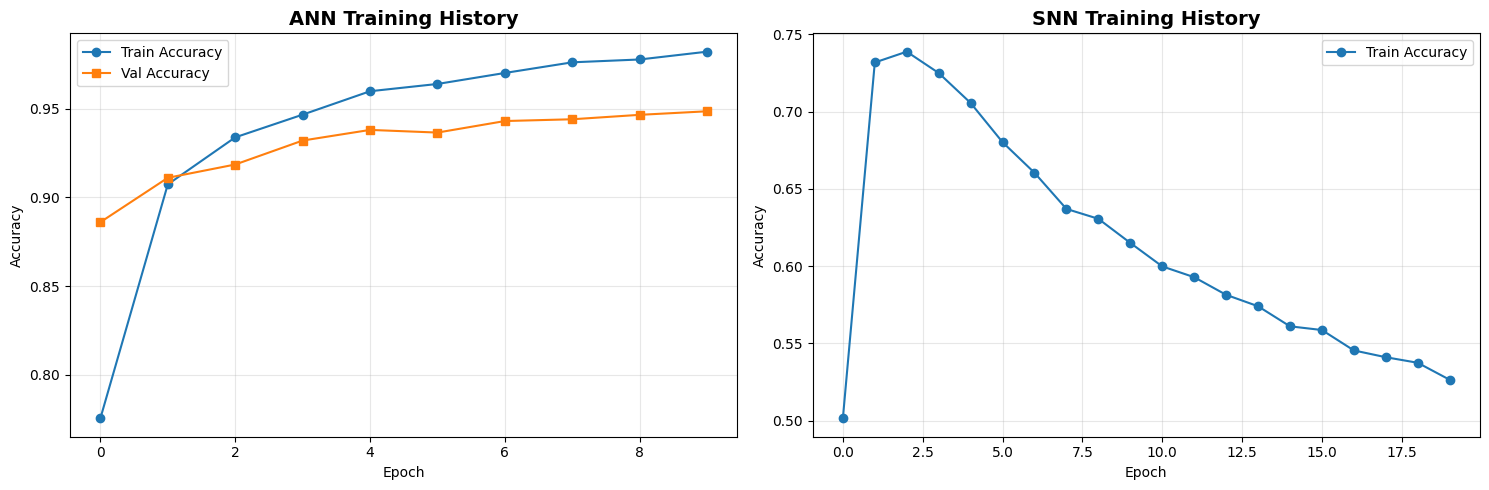

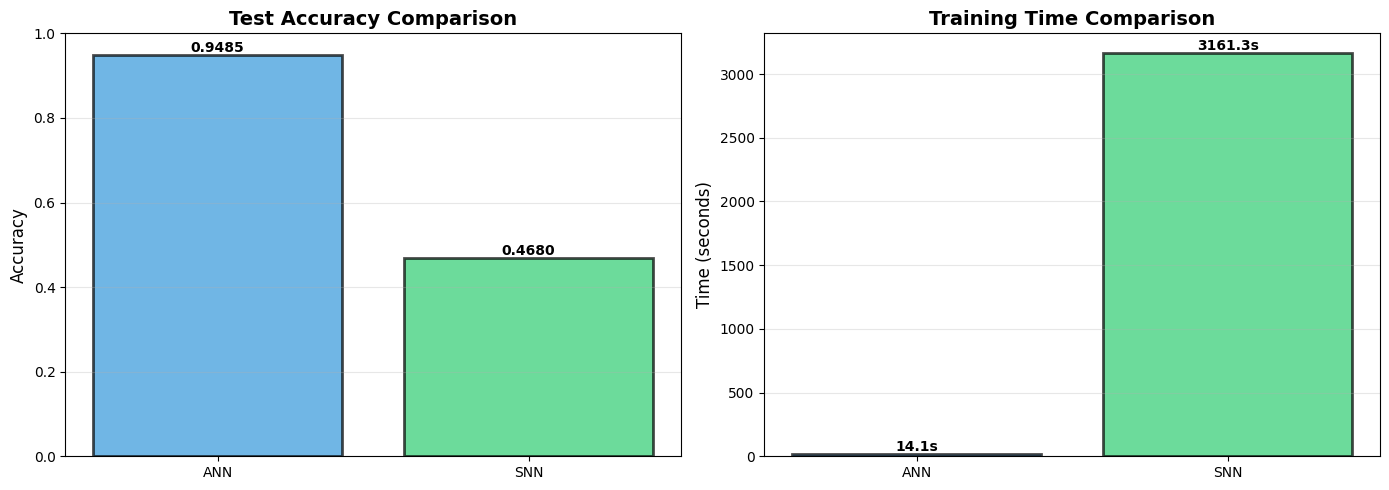

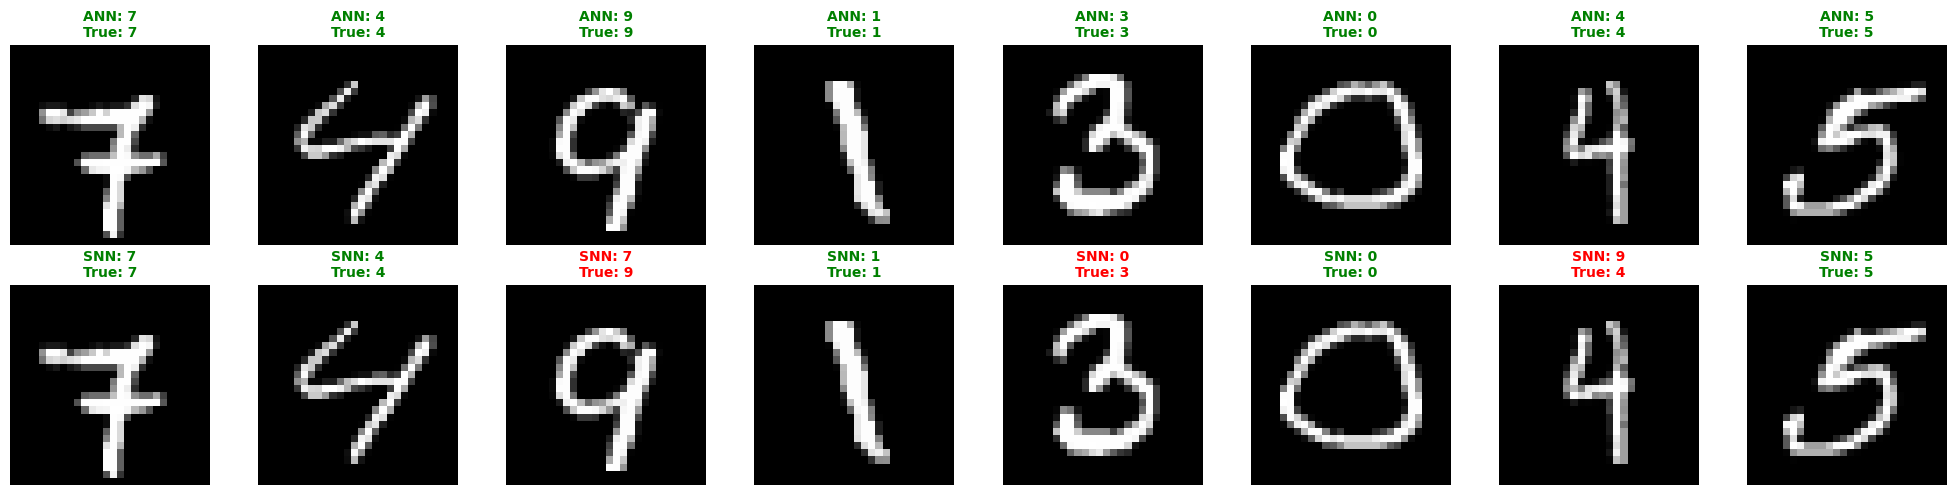


All visualizations saved!
  - training_comparison.png
  - performance_comparison.png
  - sample_predictions.png


In [28]:
if __name__ == "__main__":
    main()